In [1]:
from nn_packages import *
from io_functions import *
import numpy as np
import root_numpy as rnp
import os
import sys
import re
import glob
import h5py
import numpy as np
#import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python2.7/dist-packages/root_numpy/__init__.py:35: RuntimeWarning: numpy 1.11.1 is currently installed but you installed root_numpy against numpy 1.11.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


Welcome to ROOTaaS 6.06/04


In [2]:
def loadmodel(name):
    json_file = open('%s.json'%name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights into new model
    model.load_weights('%s_w.h5'%name)
    print (model.summary())
    print("Loaded model from disk")
    return model

def savemodel(model,name="neural network"):

    model_name = name
    model.summary()
    model.save_weights('%s.h5'%model_name, overwrite=True)
    model_json = model.to_json()
    with open("%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)
        
def savelosses(hist, name="neural network"):    
    loss = np.array(hist.history['loss'])
    valoss = np.array(hist.history['val_loss'])
    f = h5py.File("%s_losses.h5"%name,"w")
    f.create_dataset('loss',data=loss)
    f.create_dataset('val_loss',data=valoss)
    f.close()

In [ ]:
json_file = open('dnn_fixed.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dnn = model_from_json(loaded_model_json)
dnn.compile(loss='mse', optimizer='sgd')
# load weights into new model
dnn.load_weights("dnn_fixed.h5")
print("Loaded model from disk")

In [ ]:
model = loadmodel("bcnn_regcls_benchmark")

In [41]:
def list_merge(pred_list_file,pred_list):
    if(len(pred_list_file)==0):
        return pred_list
    else:
        new_list=[]
        if(len(pred_list_file)!=len(pred_list)):
            print('Unequal length')
            return pred_list_file
        for element1,element2 in zip(pred_list_file,pred_list):
            new_list.append(np.concatenate((element1,element2),axis=0))
        return new_list

In [ ]:
#For Neural Network with just ECAl data
pred_list_file = []
en_list_file = []
for i in xrange(80,101):
    print (i)
    pred_list=[]
    energy_list=[]
    fn =('/data/shared/LCD/GammaEscan_shuffled_datasets/GammaEscan_%d_shuffled.h5'%i)
    f = h5py.File(fn,'r')
    test_data = np.array(f['images'])
    test_target=np.array(f['target'])
    f.close()
    test_target = np.delete(test_target,0,1)
    test_data = test_data.reshape((test_data.shape[0],)+(1, 20, 20, 25))
    #test_data= np.reshape(test_data,(10000,-1))
    pred = cnn4.predict(test_data)
    for energy_point in np.unique(test_target):
        #print(energy_point)
        index = np.where(test_target==energy_point)
        energy_list.append(energy_point)
        energy_point_prediction = pred[index]
        #print('number of pred for ',energy_point,' is ',len(energy_point_prediction))
        pred_list.append(energy_point_prediction*110.)
    en_list = energy_list
    pred_list=[pred_list for (energy_list,pred_list) in sorted(zip(energy_list,pred_list))]
    print(len(pred_list_file),len(pred_list))
    pred_list_file = list_merge(pred_list_file,pred_list)
print(len(pred_list_file))
print(pred_list_file)
    
        

In [ ]:
#For the branched BCNN with both ECAL and HCAL data
def test_on_model(filename,model,modeltype=3,test_split=0.2):
    total_prediction = []
    total_target = []
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        print('Testing on file'+path)   
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)
                
        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(self.batch_size,-1))
            data_HCAL= np.reshape(data_HCAL,(self.batch_size,-1))
                
        pred = model.predict([data_ECAL,data_HCAL])
        total_prediction.append(pred)
        total_target.append(test_target)
        print('Finsihed Testing on file'+path)
    f = h5py.File(filename+'.h5','w')
    f.create_dataset('targets',np.array(total_target).ravel())
    f.create_dataset('predictions',np.array(total_prediction).ravel())
    f.close()
    return total_target,total_prediction

In [ ]:
#plot comparison in performance of loaded dnn and cnn models
cnn3d_zscore = []
cnn3d_residual = []
cnn3d_pcunc = []
cnn3d_mean = []
cnn3d_median = []
cnn3d_20 = []
cnn3d_60 = []
cnn3d_100 = []
cnn3d_pred = pred_list_file
pred_list_file_array = np.array(pred_list_file)
np.save('cnn3D_datagen_DOES_600_pred_list_file',pred_list_file_array)
for i in xrange(0, 100):
    print (i+10)
    test_target = i+10
    cnn3dmean= np.mean(cnn3d_pred[i])
    cnn3dmedian= np.median(cnn3d_pred[i])
    cnn3dresidual = cnn3dmedian -  test_target
    cnn3d_std = np.std(cnn3d_pred[i] - test_target)
    cnn3dzscore = (cnn3dmedian - test_target)/cnn3d_std
    cnn3dpcunc = 100*(cnn3d_std/(cnn3dmedian))
    print ("CNN_3D:", cnn3dmean, cnn3dmedian,  cnn3d_std, cnn3dzscore, cnn3dpcunc, cnn3dresidual)
    cnn3d_zscore.append(cnn3dzscore)    
    cnn3d_pcunc.append(cnn3dpcunc)
    cnn3d_residual.append(cnn3dresidual)
    cnn3d_mean.append(cnn3dmean)
    cnn3d_median.append(cnn3dmedian) 

In [ ]:
def model_stats_Escan(model_name, mean, median, residual, zscore, pcunc):
    
    e = np.arange(10,110)

    plt.figure(figsize=(12,10))
    plt.plot(e,e,linewidth=0.5)
    plt.plot(e, mean, linewidth = 1.2, linestyle = "--" )
    plt.legend(["reference", model_name],loc='best', fontsize = 15)
    plt.title("Mean prediction energy per point", fontsize = 20)
    plt.ylabel("mean prediction (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('%smeanpred.pdf'%model_name)
    plt.savefig('%smeanpred.png'%model_name)
    plt.show()

    plt.figure(figsize=(12,10))
    plt.plot(e,e,linewidth=0.5)
    plt.plot(e, median, linewidth=1.2, linestyle = "--" )
    plt.legend(["reference", model_name],loc='best', fontsize = 15)
    plt.title("Median prediction energy per point", fontsize = 20)
    plt.ylabel("Median prediction (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('%smedianpred.pdf'%model_name)
    plt.savefig('%smedianpred.png'%model_name)
    plt.show()


    plt.figure(figsize=(12,10))
    plt.plot(e, residual, linewidth=1.2, linestyle = "--")
    plt.legend([model_name],loc='best', fontsize = 15)
    plt.title("Residual", fontsize = 20)
    plt.ylabel("Residual (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('%sresidualmed.pdf'%model_name)
    plt.savefig('%sresidualmed.png'%model_name)
    plt.show()

    plt.figure(figsize=(12,10))
    plt.plot(e, zscore, linewidth=1.2, linestyle = "--")
    plt.legend([model_name],loc='best', fontsize = 15)
    plt.title("zscore", fontsize = 20)
    plt.ylabel("zscore (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('%szscoremed.pdf'%model_name)
    plt.savefig('%szscoremed.png'%model_name)
    plt.show()

    plt.figure(figsize=(12,10))
    plt.plot(e, pcunc, linewidth=1.2, linestyle = "--")
    plt.legend([model_name],loc='best', fontsize = 15)
    plt.title("% unc", fontsize = 20)
    plt.ylabel("% unc (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('%spcuncmed.pdf'%model_name)
    plt.savefig('%spcuncmed.png'%model_name)
    plt.show()
    



In [ ]:
model_stats_Escan('cnn3D_datagen_DOES_600', cnn3d_mean, cnn3d_median, cnn3d_residual, cnn3d_zscore,cnn3d_pcunc)

In [ ]:
pred_list_file = np.array(pred_list_file)
np.save('cnn3D_datagen_DOES_600_pred_list_file',pred_list_file)

In [ ]:
a = [5, 4, 3, 2 ,1]
b = ['a', 'b', 'c', 'd', 'e']
index =sorted(range(len(a)), key=lambda k: a[k])
for i in index:
    print(a[i], b[i])

In [ ]:
or i in xrange(1,101):
            self.filelist.append('/data/shared/LCD/GammaEscan_shuffled_datasets/GammaEscan_%d_shuffled.h5'%i)

In [ ]:
    #plot comparison in performance of loaded dnn and cnn models
def model_performance(model,modelname = 'cnn'):    
    model_zscore = []
    model_residual = []
    model_pcunc = []
    model_mean = []
    model_median = []
    #dnn1_mode = []
    model_20 = []
    model_60 = []
    model_100 = []

    for i in xrange(10,110):
        print (i)

        fn =('/data/kaustuv1993/GammaEscan_fulldatasets/GammaEscan_%dGeV_fulldataset.h5'%i)
        f = h5py.File(fn,'r')
        test_data = np.array(f['images'])
        test_target=np.array(f['target'])
        if(modelname.find('cnn')!=-1):
            model_test_data = np.swapaxes(test_data,1,3)
        elif(modelname.find('dnn')!=-1):
            model_test_data= np.reshape(test_data,(10000,-1))
        test_target = i/110.

        #dnn1_pred = dnn1.predict(dnn_test_data)

        #if i==20:
        #    dnn1_20.append(dnn1_pred*110.)

        #if i==60:
        #    dnn1_60.append(dnn1_pred*110.)

        #if i==100:
        #    dnn1_100.append(dnn1_pred*110.)

        #dnn1mean= np.mean(dnn1_pred*110.)
        #dnn1median= np.median(dnn1_pred*110.)
        #dnn1residual = dnn1median -  test_target
        #dnn1_std = np.std(dnn1_pred*110 - test_target)
        #dnn1zscore = (dnn1median - test_target)/dnn1_std
        #dnn1pcunc = dnn1_std/(dnn1median)
        #print ("DNN_1:", dnn1mean, dnn1median,  dnn1_std, dnn1zscore, dnn1pcunc, dnn1residual)
        #dnn1_zscore.append(dnn1zscore)    
        #dnn1_pcunc.append(dnn1pcunc)
        #dnn1_residual.append(dnn1residual)
        #dnn1_mean.append(dnn1mean)
        #dnn1_median.append(dnn1median)


        model_pred = model.predict(model_test_data)        
        modelmean= np.mean(model_pred*110.)
        modelmedian= np.median(model_pred*110.)
        modelresidual = modelmedian -  test_target
        model_std = np.std(model_pred*110 - test_target)
        modelzscore = (modelmedian - test_target)/cnn1_std
        modelpcunc = cnn1_std/(modelmedian)
        print ("CNN_1:", modelmean, modelmedian, model_std, modelzscore, modelpcunc, modelresidual)
        model_zscore.append(modelzscore)    
        model_pcunc.append(modelpcunc)
        model_residual.append(modelresidual)
        model_mean.append(modelmean)
        model_median.append(modelmedian)
        f.close()


In [ ]:
prediction = np.load('bcnn_1_predictions.npy')
target = np.load('bcnn_1_targets.npy')

In [ ]:
print(prediction.shape,target.shape)

In [ ]:
print(prediction*500.,target)

In [ ]:
a = np.arange(1,17).reshape((4,4))

In [ ]:
a

In [ ]:
a = np.zeros((2,3))
b = np.ones((2,3))
c = np.ones((2,3))*2

In [ ]:
print(a)
print(b)
print(c)

In [ ]:
def convert(filename):
    f = h5py.File(filename,'r')
    HCAL = np.array(f['HCAL'])
    print(HCAL)
    ECAL = np.array(f['ECAL'])
    print(ECAL)
    target=np.array(f['target'])
    print(target)
    f.close()
    np.savez_compressed(filename.replace('.h5','.npz'), HCAL=HCAL,ECAL=ECAL,target=target)

In [ ]:
convert('/data/shared/LCD/New_Data/GammaEscan_5_1.h5')

In [ ]:
data = np.load('/data/shared/LCD/New_Data/GammaEscan_5_1.npz')

In [ ]:
data.files

In [ ]:
print(data['HCAL'])
print(data['ECAL'])
print(data['target'])

In [ ]:
#Code to plot the target energy distribution
filelist=[]
target_list=[]
for i in xrange(1,6):
    for j in xrange(1,11):
        filelist.append('/data/shared/LCD/New_Data/GammaEscan_%d_%d.h5'%(i,j))
for fn in filelist:
    print(fn)
    f = h5py.File(fn,'r')
    test_target = np.array(f['target'][:,:,1])
    f.close()
    #for i in xrange(0,test_target.shape[0]):
        #test_target[i]=round(test_target[i])
    #print(len(np.unique(test_target)))
    target_list.extend(test_target)
#print('Finished creating the list, creating the text file')
print(len(target_list))
fn ='target_list_pi0.txt'
f = open(fn,'w')
for item in target_list:
    #f.write("%f\n" % float(item))
f.close()
print('Finished making the text file')

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(target_list, label='energy ',bins=500)
plt.legend()
plt.show()

In [ ]:
scan_files()

In [ ]:
print(round(5.4,0))

In [ ]:
f.keys()

In [ ]:
fn = 'final_keras_mods_bcnn_hist.h5'
f = h5py.File(fn,'r')
energy_loss = f['energy_losses']
loss = f['loss']
plabel_loss = f['plabel_losses']
val_energy_loss = f['val_energy_losses']
val_loss = f['val_loss']
val_plabelloss = f['val_plabel_losses']


In [ ]:
model = loadmodel('final_keras_mods_bcnn_regcls')
model.summary()

In [ ]:
total_target,total_prediction = test_on_model(model=model,filename='final_keras_mods_bcnn_regcls_test')

In [ ]:
plt.figure(figsize=(12,10))
plt.yscale('log')
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title('Training Error by Epoch', fontsize = 20)
plt.plot(loss)
plt.plot(plabel_loss)
plt.plot(energy_loss)
plt.plot(val_loss, linestyle="--")
plt.plot(val_plabelloss, linestyle ="--")
plt.plot(val_energy_loss, linestyle ="--")
plt.legend(f.keys(),loc='best', fontsize = 16, fancybox=True, framealpha=0.01)
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)
#plt.ylim(0.0, 0.1)
#plt.xlim(60, 112)
plt.savefig("final_keras_mods_bcnn_regcls.pdf")
plt.savefig("final_keras_mods_regcls.png")

In [ ]:
fn ='val_plabelloss.txt'
f = open(fn,'w')
for item in list(val_plabelloss):
    f.write("%f\n" % float(item))
f.close()
print('finished')

In [ ]:
fn = 'final_keras_mods_bcnn_regcls_h.h5'
f = h5py.File(fn,'r')
f.keys()

In [ ]:
model = loadmodel("/data/shared/LCD/Final/Classification/bcnn1_cl")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 1, 24, 24, 25) 0                                            
____________________________________________________________________________________________________
input_28 (InputLayer)            (None, 1, 4, 4, 60)   0                                            
____________________________________________________________________________________________________
convolution3d_31 (Convolution3D) (None, 3, 21, 21, 21) 243         input_27[0][0]                   
____________________________________________________________________________________________________
convolution3d_32 (Convolution3D) (None, 10, 3, 3, 55)  250         input_28[0][0]                   
___________________________________________________________________________________________

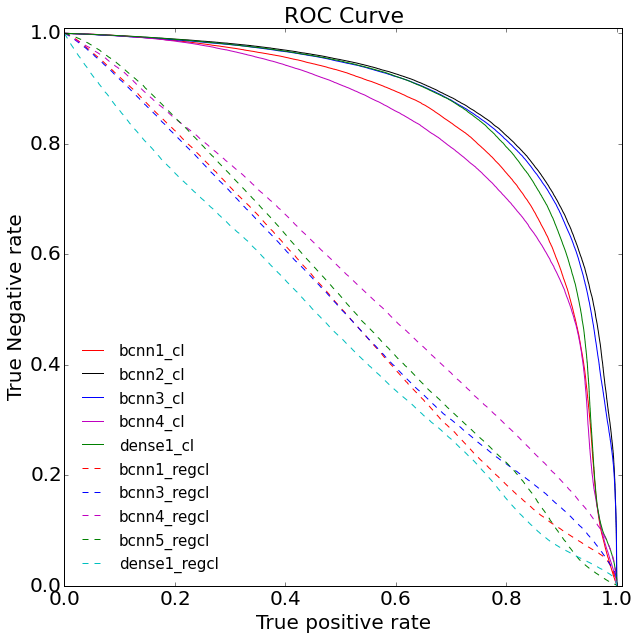

In [14]:
#Kaustuv test model
#For the branched BCNN with both ECAL and HCAL data
#ROC curve for classification models
#model_names=['bcnn1_cl','bcnn2_cl','bcnn3_cl','bcnn5_cl', 'dense1_cl']
cl_col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
plt.figure(figsize=(10,10))
for k in xrange(1,7):
    modeltype=3
    if k==5:
        continue
    filename='bcnn%d_cl'%k
    if k==6:
        filename='dense1_cl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,101):
        #for j in xrange(1,11):
        filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%(i))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,0])

        #print('Testing on file'+path)   
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
        f.close()
    fpr, tpr, _ = roc_curve(total_target,total_prediction)
    #plt.legend(model_names, loc = 'best',fontsize = 15, fancybox=True, framealpha=0.01)
    plt.xlabel('True positive rate',fontsize=20)
    plt.ylabel('True Negative rate',fontsize=20)
    plt.rc('xtick', labelsize = 20)
    plt.rc('ytick', labelsize = 20)
    plt.xlim([.0, 1.01])
    plt.ylim([.0, 1.01])
    plt.plot( tpr, 1-fpr ,label=filename, color=cl_col[temp])
    temp=temp+1
    plt.legend(loc = 'best',fontsize = 15, fancybox=True, framealpha=0)

regcl_col = ['r','b', 'm', 'g', 'c']
temp=0    
for k in xrange(1,7):
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,101):
        #for j in xrange(1,11):
        filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%(i))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,0])
        f.close()
        #print('Testing on file'+path)   
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred = pred[0]
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    fpr, tpr, _ = roc_curve(total_target,total_prediction)
    plt.xlabel('True positive rate',fontsize=20)
    plt.ylabel('True Negative rate',fontsize=20)
    plt.rc('xtick', labelsize = 20)
    plt.rc('ytick', labelsize = 20)
    plt.xlim([.0, 1.01])
    plt.ylim([.0, 1.01])
    plt.title("ROC Curve", fontsize=22)
    plt.plot( tpr, 1-fpr ,linestyle='--', color=regcl_col[temp], label = filename)
    temp=temp+1
    plt.legend(loc = 'best',fontsize = 15, fancybox=True, framealpha=0)    
plt.savefig('all_roc_tn_vs_tp.png')
plt.savefig('all_roc_tn_vs_tp.pdf')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 1, 24, 24, 25) 0                                            
____________________________________________________________________________________________________
input_28 (InputLayer)            (None, 1, 4, 4, 60)   0                                            
____________________________________________________________________________________________________
convolution3d_31 (Convolution3D) (None, 3, 21, 21, 21) 243         input_27[0][0]                   
____________________________________________________________________________________________________
convolution3d_32 (Convolution3D) (None, 10, 3, 3, 55)  250         input_28[0][0]                   
___________________________________________________________________________________________

KeyboardInterrupt: 

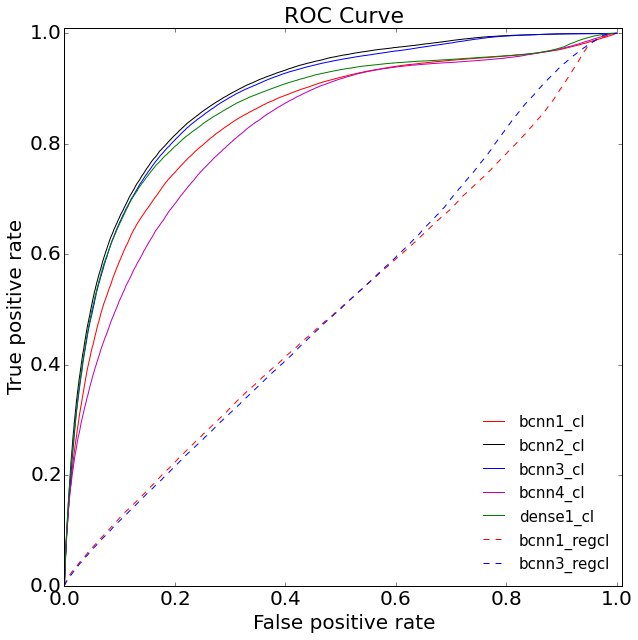

In [15]:
#Kaustuv test model
#For the branched BCNN with both ECAL and HCAL data
#ROC curve for classification models tp vs fp
#model_names=['bcnn1_cl','bcnn2_cl','bcnn3_cl','bcnn5_cl', 'dense1_cl']
cl_col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
plt.figure(figsize=(10,10))
for k in xrange(1,7):
    modeltype=3
    if k==5:
        continue
    filename='bcnn%d_cl'%k
    if k==6:
        filename='dense1_cl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,101):
        #for j in xrange(1,11):
        filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%(i))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,0])

        #print('Testing on file'+path)   
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
        f.close()
    fpr, tpr, _ = roc_curve(total_target,total_prediction)
    #plt.legend(model_names, loc = 'best',fontsize = 15, fancybox=True, framealpha=0.01)
    plt.xlabel('False positive rate',fontsize=20)
    plt.ylabel('True positve rate',fontsize=20)
    plt.rc('xtick', labelsize = 20)
    plt.rc('ytick', labelsize = 20)
    plt.xlim([.0, 1.01])
    plt.ylim([.0, 1.01])
    plt.plot( fpr, tpr ,label=filename, color=cl_col[temp])
    temp=temp+1
    plt.legend(loc = 'best',fontsize = 15, fancybox=True, framealpha=0)

regcl_col = ['r','b', 'm', 'g', 'c']
temp=0    
for k in xrange(1,7):
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,101):
        #for j in xrange(1,11):
        filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%(i))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,0])
        f.close()
        #print('Testing on file'+path)   
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred = pred[:,0]
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    fpr, tpr, _ = roc_curve(total_target,total_prediction)
    plt.xlabel('False positive rate',fontsize=20)
    plt.ylabel('True positive rate',fontsize=20)
    plt.rc('xtick', labelsize = 20)
    plt.rc('ytick', labelsize = 20)
    plt.xlim([.0, 1.01])
    plt.ylim([.0, 1.01])
    plt.title("ROC Curve", fontsize=22)
    plt.plot( fpr, tpr ,linestyle='--', color=regcl_col[temp], label = filename)
    temp=temp+1
    plt.legend(loc = 'best',fontsize = 15, fancybox=True, framealpha=0)    
plt.savefig('all_roc_tp_vs_fp.png')
plt.savefig('all_roc_tp_vs_fp.pdf')

In [ ]:
plt.savefig('classification_roc.pdf')

In [ ]:
#For the branched BCNN with both ECAL and HCAL data
#Regression plots
plt.figure(figsize=(10,10))
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_reg'%k
    if k==6:
        filename='dense1_reg'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    e = np.arange(10,501)
    plt.figure(figsize=(12,10))
    plt.plot(e,e,linewidth=0.5)
    print(mean_list)
    plt.plot(e, mean_list, linestyle = "--" ,label=filename)
    plt.legend(loc='best', fontsize = 15)
    plt.title("Mean prediction energy per point", fontsize = 20)
    plt.ylabel("Mean prediction (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('plots/cscs_mean_pred'+filename+'.pdf')
    plt.savefig('plots/cscs_mean_pred'+filename+'.png')
    plt.show()
        
    #Median plots
    e = np.arange(10,501)
    plt.figure(figsize=(12,10))
    plt.plot(e,e,linewidth=0.5)
    plt.plot(e, median_list, linestyle = "--" ,label=filename)
    plt.legend(loc='best', fontsize = 15)
    plt.title("Median prediction energy per point", fontsize = 20)
    plt.ylabel("Median prediction (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('plots/cscs_median_pred'+filename+'.pdf')
    plt.savefig('plots/cscs_median_pred'+filename+'.png')
    plt.show()
        
    #Residual plots
    e = np.arange(10,501)
    plt.figure(figsize=(12,10))
    #plt.plot(e,e,linewidth=0.5)
    plt.plot(e, residual_list, linestyle = "--" ,label=filename)
    plt.legend(loc='best', fontsize = 15)
    plt.title("Residual", fontsize = 20)
    plt.ylabel("Residual (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('plots/cscs_residual_pred'+filename+'.pdf')
    plt.savefig('plots/cscs_residual_pred'+filename+'.png')
    plt.show()
        
    #Zscore plots
    e = np.arange(10,501)
    plt.figure(figsize=(12,10))
    #plt.plot(e,e,linewidth=0.5)
    plt.plot(e, residual_list, linestyle = "--" ,label=filename)
    plt.legend(loc='best', fontsize = 15)
    plt.title("Zscore", fontsize = 20)
    plt.ylabel("Zscore (GeV)", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('plots/cscs_zscore_pred'+filename+'.pdf')
    plt.savefig('plots/cscs_zscore_pred'+filename+'.png')
    plt.show()
    
    #Percentage Uncertainty plots
    e = np.arange(10,501)
    plt.figure(figsize=(12,10))
    #plt.plot(e,e,linewidth=0.5)
    plt.plot(e, residual_list, linestyle = "--" ,label=filename)
    plt.legend(loc='best', fontsize = 15)
    plt.title("Percentage Uncertainty", fontsize = 20)
    plt.ylabel("Percentage Uncertainty", fontsize = 20)
    plt.xlabel("Energy (GeV)", fontsize = 20)
    plt.rc('xtick', labelsize = 18)
    plt.rc('ytick', labelsize = 18)
    plt.savefig('plots/cscs_punc_pred'+filename+'.pdf')
    plt.savefig('plots/cscs_punc_pred'+filename+'.png')
    plt.show()
        
#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 24, 24, 25) 0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1, 4, 4, 60)   0                                            
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 10, 21, 21, 21)810         input_1[0][0]                    
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 10, 3, 3, 55)  250         input_2[0][0]                    
___________________________________________________________________________________________

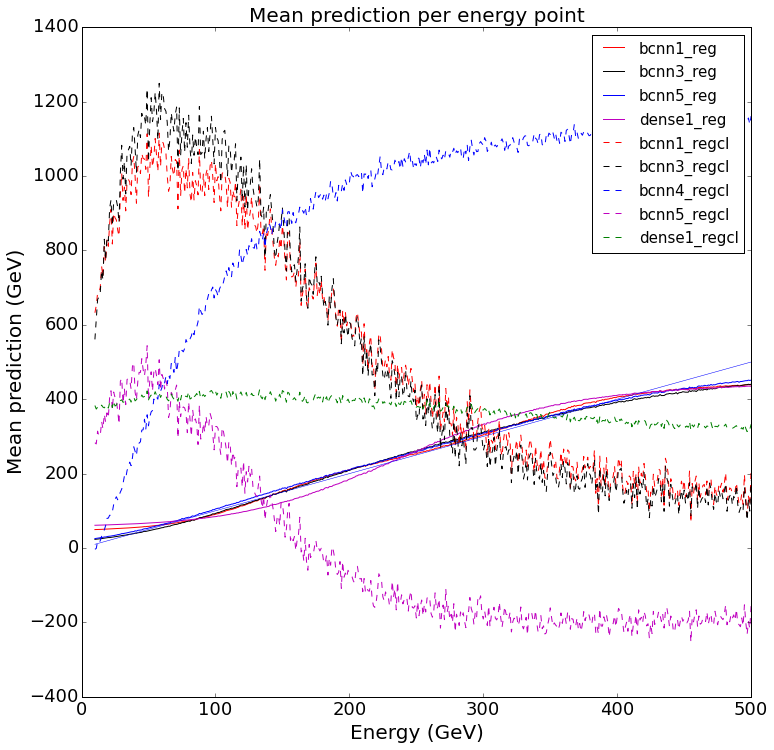

In [12]:
#For the branched BCNN with both ECAL and HCAL data
#Regression plots (Mean)
#All models in same plot
plt.figure(figsize=(12,12))
e = np.arange(10,501)
col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2or k==4:
        continue
    filename='bcnn%d_reg'%k
    if k==6:
        filename='dense1_reg'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, mean_list,label=filename, color=col[temp])
    temp = temp+1
    
temp=0   
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred = pred[1]
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, mean_list, linestyle = "--" ,label=filename, color=col[temp])
    temp = temp+1
   
plt.legend(loc='best', fontsize = 15)
plt.plot(e,e,linewidth=0.5)
plt.title("Mean prediction per energy point", fontsize = 20)
plt.ylabel("Mean prediction (GeV)", fontsize = 20)
plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_mean_pred_all_now.pdf')
plt.savefig('plots/cscs_mean_pred_all_now.png')
plt.show()


#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 24, 24, 25) 0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1, 4, 4, 60)   0                                            
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 10, 21, 21, 21)810         input_1[0][0]                    
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 10, 3, 3, 55)  250         input_2[0][0]                    
___________________________________________________________________________________________

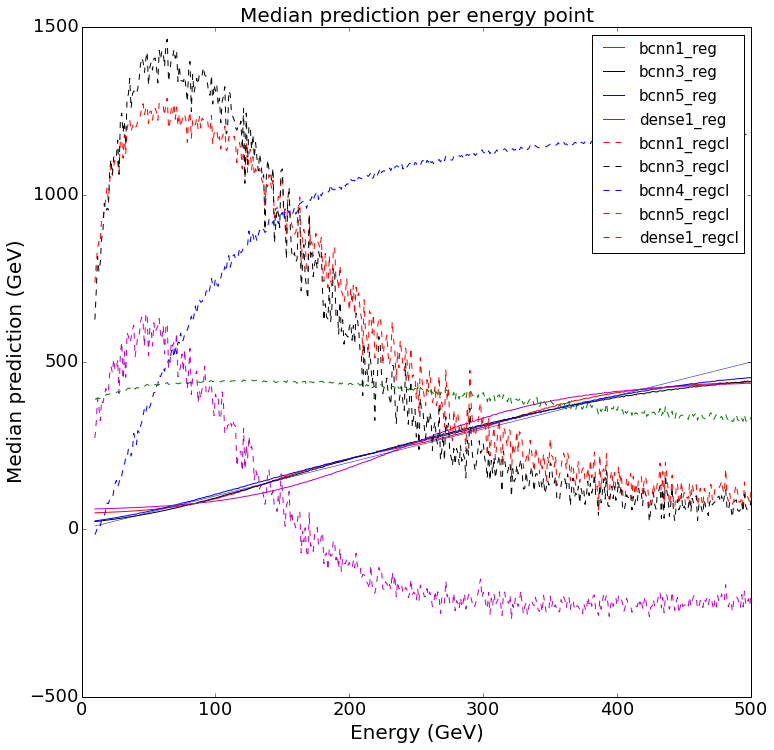

In [10]:
#For the branched BCNN with both ECAL and HCAL data
#Regression plots (Median)
#All models in same plot
plt.figure(figsize=(12,12))
e = np.arange(10,501)
col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2 or k==4:
        continue
    filename='bcnn%d_reg'%k
    if k==6:
        filename='dense1_reg'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, median_list,label=filename, color=col[temp])
    temp = temp+1
    
temp=0   
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred = pred[1]
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, median_list, linestyle = "--" ,label=filename, color=col[temp])
    temp = temp+1
    
plt.legend(loc='best', fontsize = 15)
plt.plot(e,e,linewidth=0.5)
plt.title("Median prediction per energy point", fontsize = 20)
plt.ylabel("Median prediction (GeV)", fontsize = 20)
plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_median_pred_all.pdf')
plt.savefig('plots/cscs_median_pred_all.png')
plt.show()


#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')

In [ ]:
#For the branched BCNN with both ECAL and HCAL data
#Regression plots (Residual)
#All models in same plot
plt.figure(figsize=(12,12))
e = np.arange(10,501)
col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_reg'%k
    if k==6:
        filename='dense1_reg'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, residual_list,label=filename, color=col[temp])
    temp = temp+1
    
temp=0   
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred = pred[1]
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, residual_list, linestyle = "--" ,label=filename, color=col[temp])
    temp = temp+1
    
plt.legend(loc='best', fontsize = 15)
#plt.plot(e,e,linewidth=0.5)
plt.title("Residual", fontsize = 20)
plt.ylabel("Residual (GeV)", fontsize = 20)
plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_residual_pred_all.pdf')
plt.savefig('plots/cscs_residual_pred_all.png')
plt.show()


#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')

In [ ]:
#For the branched BCNN with both ECAL and HCAL data
#Regression plots (Zscore)
#All models in same plot
plt.figure(figsize=(12,12))
e = np.arange(10,501)
col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_reg'%k
    if k==6:
        filename='dense1_reg'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, zscore_list,label=filename, color=col[temp])
    temp = temp+1
    
temp=0   
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred = pred[1]
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append(std/median)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, zscore_list, linestyle = "--" ,label=filename, color=col[temp])
    temp = temp+1
    
plt.legend(loc='best', fontsize = 15)
#plt.plot(e,e,linewidth=0.5)
plt.title("Zscore", fontsize = 20)
plt.ylabel("Zscore", fontsize = 20)
plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_zscore_pred_all.pdf')
plt.savefig('plots/cscs_zscore_pred_all.png')
plt.show()


#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')

In [ ]:
#For the branched BCNN with both ECAL and HCAL data
#Regression plots (percentage uncertainty)
#All models in same plot
plt.figure(figsize=(12,12))
e = np.arange(10,501)
col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_reg'%k
    if k==6:
        filename='dense1_reg'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append((std/median)*100.)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, punc_list,label=filename, color=col[temp])
    temp = temp+1
    
temp=0   
for k in xrange(1,7):
    energy_list=[]
    mean_list=[]
    median_list=[]
    residual_list=[]
    zscore_list=[]
    punc_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,6):
        for j in xrange(1,11):
            filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaEscan_%d_%d.h5'%(i,j))
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,1])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred = pred[1]
        print('test target shape is',test_target.shape)
        #print('pred shape is',pred.shape)
        if c==0:
            total_prediction = pred
            total_target = test_target
            #rel_pred = (pred[1]*500.-test_target)
        else:
            total_prediction = np.concatenate((total_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)
            #rel_pred = np.concatenate((rel_pred, (pred[1]*500.-test_target)), axis=0)
        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target = total_target.round()
    #print(total_target)
    for energy_point in np.unique(total_target):
        #print(energy_point)
        index = np.where(total_target==energy_point)
        energy_list.append(energy_point)
        energy_point_predictions = total_prediction[index]
        #print(energy_point_predictions)
        mean_list.append(np.mean(energy_point_predictions*500.))
        median = np.median(energy_point_predictions*500.)
        median_list.append(median)
        residual_list.append(median-energy_point)
        std = np.std(energy_point_predictions*500. - energy_point)
        zscore_list.append((median - energy_point)/std)
        punc_list.append((std/median)*100.)
        #performance plots
        
    #Mean plots
    #print(mean_list)
    plt.plot(e, punc_list, linestyle = "--" ,label=filename, color=col[temp])
    temp = temp+1
    
plt.legend(loc='best', fontsize = 15)
#plt.plot(e,e,linewidth=0.5)
plt.title("", fontsize = 20)
plt.ylabel("Percentage Uncertainty", fontsize = 20)
plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_punc_pred_all.pdf')
plt.savefig('plots/cscs_punc_pred_all.png')
plt.show()


#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')

In [ ]:
#For the branched BCNN with both ECAL and HCAL data

#Classification plots (Area Under Curve)
#All models in same plot
plt.figure(figsize=(12,12))
e = np.arange(10,501)
col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
for k in xrange(1,7):
    roc_auc_score_list=[]
    energy_list = []
    modeltype=3
    if k==5:
        continue
    filename='bcnn%d_cl'%k
    if k==6:
        filename='dense1_cl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_classification_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,101):
           filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%i)
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,0:2])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))
        print(filename)
        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        print('pred shape is',pred.shape)
        if c==0:
            total_classification_prediction = pred
            total_target = test_target

        else:
            total_classification_prediction = np.concatenate((total_classification_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)

        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target[:,:,1] = total_target[:,:,1].round()
    #print(total_target)
    for energy_point in np.unique(total_target[:,:,1]):
        #print(energy_point)
        index = np.where(total_target[:,:,1]==energy_point)
        energy_list.append(energy_point)
        energy_point_classification_predictions = total_classification_prediction[index]
        #print(energy_point_predictions)
        roc_auc_score_list.append(roc_auc_score(total_target[:,:,0][index],energy_point_classification_predictions))
        
    #performance plots
        
    #Area Under Curve plot
    plt.plot(e, roc_auc_score_list,label=filename, color=col[temp])
    temp = temp+1
    
temp=0 

for k in xrange(1,7):
    roc_auc_score_list=[]
    energy_list = []
    modeltype=3
    if k==2:
        continue
    filename='bcnn%d_regcl'%k
    if k==6:
        filename='dense1_regcl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Regression_Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_classification_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,101):
           filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%i)
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,0:2])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        pred=pred[0]
        print('test target shape is',test_target.shape)
        print('pred shape is',pred.shape)
        if c==0:
            total_classification_prediction = pred
            total_target = test_target

        else:
            total_classification_prediction = np.concatenate((total_classification_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)

        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target[:,:,1] = total_target[:,:,1].round()
    #print(total_target)
    for energy_point in np.unique(total_target[:,:,1]):
        #print(energy_point)
        index = np.where(total_target[:,:,1]==energy_point)
        energy_list.append(energy_point)
        energy_point_classification_predictions = total_classification_prediction[index]
        #print(energy_point_predictions)
        roc_auc_score_list.append(roc_auc_score(total_target[:,:,0][index],energy_point_classification_predictions))
        
    #performance plots
        
    #Area Under Curve plot
    plt.plot(e, roc_auc_score_list,linestyle='--',label=filename, color=col[temp])
    temp = temp+1

    
plt.legend(loc='best', fontsize = 15)
#plt.plot(e,e,linewidth=0.5)
plt.title("Area Under the Curve", fontsize = 20)
#plt.ylabel("", fontsize = 20)
#plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_area_under_curve_all.pdf')
plt.savefig('plots/cscs_area_under_curve_all.png')
plt.show()


#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 1, 24, 24, 25) 0                                            
____________________________________________________________________________________________________
input_28 (InputLayer)            (None, 1, 4, 4, 60)   0                                            
____________________________________________________________________________________________________
convolution3d_31 (Convolution3D) (None, 3, 21, 21, 21) 243         input_27[0][0]                   
____________________________________________________________________________________________________
convolution3d_32 (Convolution3D) (None, 10, 3, 3, 55)  250         input_28[0][0]                   
___________________________________________________________________________________________

In [62]:
def roc_90_score(tpr,fpr):
    index = np.argmax(tpr>=0.9)
    return fpr[index]
    

In [ ]:
#For the branched BCNN with both ECAL and HCAL data

#Classification plots (90% cut)
#All models in same plot
plt.figure(figsize=(20,10))  
e = np.arange(10,501)
col = ['r', 'k', 'b','m', 'g', 'c']
temp=0
for k in xrange(1,7):
    roc_90_score_list=[]
    energy_list = []
    modeltype=3
    if k==5:
        continue
    filename='bcnn%d_cl'%k
    if k==6:
        filename='dense1_cl'
        modeltype=1
    model = loadmodel("/data/shared/LCD/Final/Classification/%s"%filename)
    if k==5:
        modeltype=2
    test_split=0.2
    total_classification_prediction = None
    total_target = None
    rel_pred = None
    filelist=[]
    for i in xrange(1,101):
           filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%i)
    length = len(filelist)
    #deleting the train and validation set filenames from the filelist
    del filelist[:np.floor((1-test_split)*length).astype(int)+1]
    c=0
    for path in filelist:
        f = h5py.File(path,'r')
        data_ECAL = np.array(f['ECAL'])
        data_HCAL = np.array(f['HCAL'])
        test_target = np.array(f['target'][:,:,0:2])
        f.close()
        #print('Testing on file'+path)
        if modeltype==3:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))

        elif modeltype==2:
            data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(24, 24, 25))
            data_ECAL = np.swapaxes(data_ECAL, 1, 3)
            data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(4, 4, 60))
            data_HCAL = np.swapaxes(data_HCAL, 1, 3)

        elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))
        pred = np.array(model.predict([data_ECAL,data_HCAL]))
        print('test target shape is',test_target.shape)
        if c==0:
            total_classification_prediction = pred
            total_target = test_target

        else:
            total_classification_prediction = np.concatenate((total_classification_prediction, pred), axis=0)
            total_target = np.concatenate((total_target, test_target), axis=0)

        c=c+1
        #print('Finsihed Testing on file'+path)
    total_target[:,:,1] = total_target[:,:,1].round()
    #print(total_target)
    for energy_point in np.unique(total_target[:,:,1]):
        #print(energy_point)
        index = np.where(total_target[:,:,1]==energy_point)
        energy_list.append(energy_point)
        energy_point_classification_predictions = total_classification_prediction[index]
        #print(energy_point_predictions)
        fpr, tpr, _ = roc_curve(total_target[:,:,0][index],energy_point_classification_predictions)
        roc_90_score_list.append(roc_90_score(tpr,fpr))
        
    #performance plots
        
    #Area Under Curve plot
    plt.plot(e, roc_90_score_list,label=filename, color=col[temp])
    temp = temp+1

plt.legend(loc='best', fontsize = 15)
#plt.plot(e,e,linewidth=0.5)
#plt.title("", fontsize = 20)
plt.ylabel("False positive rate at 90% True positive rate", fontsize = 20)
plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_90tpr_cutoff_all.pdf')
plt.savefig('plots/cscs_90tpr_cutoff_all.png')
plt.show()


#plt.savefig('classification_regcl_roc.png')
#plt.savefig('classification_regcl_roc.pdf')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 1, 24, 24, 25) 0                                            
____________________________________________________________________________________________________
input_28 (InputLayer)            (None, 1, 4, 4, 60)   0                                            
____________________________________________________________________________________________________
convolution3d_31 (Convolution3D) (None, 3, 21, 21, 21) 243         input_27[0][0]                   
____________________________________________________________________________________________________
convolution3d_32 (Convolution3D) (None, 10, 3, 3, 55)  250         input_28[0][0]                   
___________________________________________________________________________________________

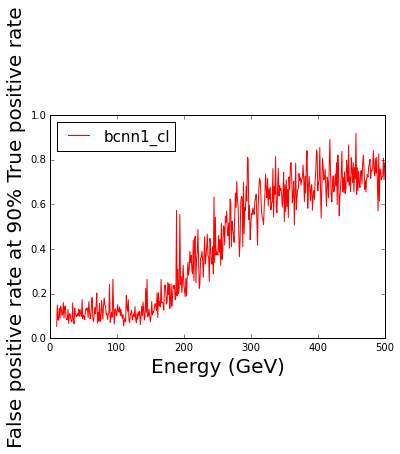

In [67]:
plt.plot(e, roc_90_score_list,label=filename, color=col[temp])
temp = temp+1
    
plt.legend(loc='best', fontsize = 15)
#plt.plot(e,e,linewidth=0.5)
#plt.title("", fontsize = 20)
plt.ylabel("False positive rate at 90% True positive rate", fontsize = 20)
plt.xlabel("Energy (GeV)", fontsize = 20)
plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)
plt.savefig('plots/cscs_90tpr_cutoff_all.pdf')
plt.savefig('plots/cscs_90tpr_cutoff_all.png')
plt.show()

In [4]:
modeltype = 3
filename='bcnn1_cl'
model = loadmodel("/data/shared/LCD/Final/Classification/%s"%filename)

test_split=0.2
total_prediction = None
total_target = None
rel_pred = None
filelist=[]
for i in xrange(1,20):
    #for j in xrange(1,11):
    filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%(i))
length = len(filelist)
#deleting the train and validation set filenames from the filelist
del filelist[:np.floor((1-test_split)*length).astype(int)+1]
c=0
for path in filelist:
    f = h5py.File(path,'r')
    data_ECAL = np.array(f['ECAL'])
    data_HCAL = np.array(f['HCAL'])
    test_target = np.array(f['target'][:,:,0])
    f.close()
    #print('Testing on file'+path)   
    if modeltype==3:
        data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
        data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))
        
pred = np.array(model.predict([data_ECAL,data_HCAL]))
print('test target shape is',test_target)
#print(pred)
#print((test_target,pred))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 1, 24, 24, 25) 0                                            
____________________________________________________________________________________________________
input_28 (InputLayer)            (None, 1, 4, 4, 60)   0                                            
____________________________________________________________________________________________________
convolution3d_31 (Convolution3D) (None, 3, 21, 21, 21) 243         input_27[0][0]                   
____________________________________________________________________________________________________
convolution3d_32 (Convolution3D) (None, 10, 3, 3, 55)  250         input_28[0][0]                   
___________________________________________________________________________________________

In [61]:
fpr, tpr, _ = roc_curve(test_target,pred)
print(roc_90_score(tpr,fpr))

0.43279729998


In [36]:
modeltype = 1
filename='dense1_regcl'
name = "/data/shared/LCD/Final/Regression_Classification/%s"%filename
json_file = open('%s.json'%name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
#load weights into new model
model.load_weights('%s_check.h5'%name)
print (model.summary())
print("Loaded model from disk")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 14400)         0                                            
____________________________________________________________________________________________________
input_12 (InputLayer)            (None, 960)           0                                            
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 10000)         144010000   input_11[0][0]                   
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 10000)         9610000     input_12[0][0]                   
___________________________________________________________________________________________

In [37]:
test_split=0.2
total_prediction = None
total_target = None
rel_pred = None
filelist=[]
for i in xrange(1,20):
    #for j in xrange(1,11):
    filelist.append('/data/shared/LCD/New_Data_Shuffled/GammaPi0_shuffled_%d.h5'%(i))
length = len(filelist)
#deleting the train and validation set filenames from the filelist
del filelist[:np.floor((1-test_split)*length).astype(int)+1]
c=0
for path in filelist:
    f = h5py.File(path,'r')
    data_ECAL = np.array(f['ECAL'])
    data_HCAL = np.array(f['HCAL'])
    test_target = np.array(f['target'][:,:,0])
    f.close()
    #print('Testing on file'+path)   
    if modeltype==3:
        data_ECAL = data_ECAL.reshape((data_ECAL.shape[0],)+(1, 24, 24, 25))
        data_HCAL = data_HCAL.reshape((data_HCAL.shape[0],)+(1, 4, 4, 60))
    elif modeltype==1:
            data_ECAL= np.reshape(data_ECAL,(data_ECAL.shape[0],-1))
            data_HCAL= np.reshape(data_HCAL,(data_HCAL.shape[0],-1))

        
pred = np.array(model.predict([data_ECAL,data_HCAL]))
print('test target shape is',test_target)
#print(pred)
#print((test_target,pred))

('test target shape is', array([[ 1.],
       [ 0.],
       [ 1.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]]))


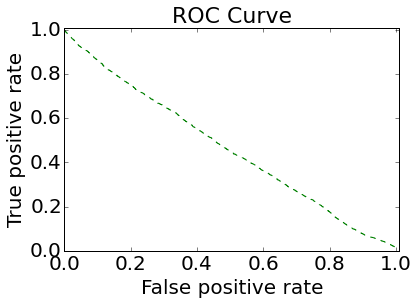

In [38]:
fpr, tpr, _ = roc_curve(test_target,pred[0])
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.xlim([.0, 1.01])
plt.ylim([.0, 1.01])
plt.title("ROC Curve", fontsize=22)
plt.plot( tpr, 1-fpr ,linestyle='--', color='g', label = filename)